In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils

In [2]:
runs = ELPH_utils.load_runs()

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)


for k in range(len(runs)):
    runs[k] = runs[k][:,:200:2]

100 loaded with n_kmax = 80


runs[0] shape:  (80, 100)


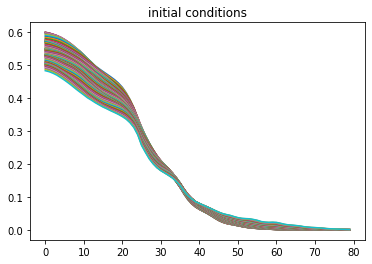

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('initial conditions')
plt.show()

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 9900)
NVAR state shape:  (861, 9900)
target shape:  (20, 9900)
weights shape:  (861, 20)


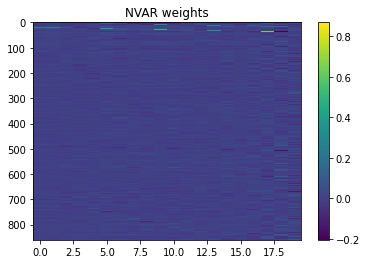

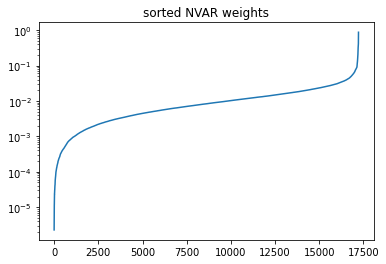

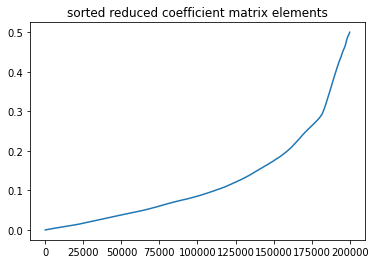

In [24]:
from ELPH_NVAR import SVDNVAR

NVAR = SVDNVAR(runs)
NVAR.train(alpha=10**-3.4, rdim=20, n_VAR_steps=2, NVAR_p=2, standardize=True, intercept=True)
NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()


plt.plot(np.sort(np.ravel(np.abs(NVAR.red_coef_matrix))))
plt.title('sorted reduced coefficient matrix elements')
plt.show()

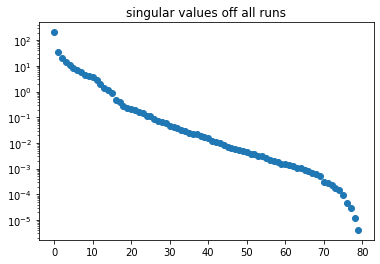

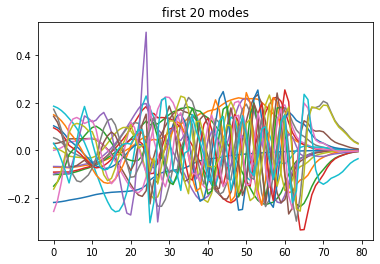

In [5]:
plt.semilogy(NVAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(NVAR.rdim):
  plt.plot(NVAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(NVAR.rdim) + ' modes')
plt.show()

In [27]:
train_kwargs = {'alpha':10**-3.4, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'standardize':True, 'full_hist':False}
score_kwargs = {'norm':'max', 'errSVD':True}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.0017589451888947005
0.0004668293448134648
[0.002182422115276676, 0.002370032330192088, 0.0012923718817148245, 0.0017559218548334934, 0.0011939777624564204]


In [7]:
def get_BayO_score(aExp):
    alpha = 10.0**aExp
    
    train_kwargs = {'alpha':alpha, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'standardize':False}
    score_kwargs = {'norm':'fro', 'errSVD':False}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    return -1.*m - 1.*np.std(s)

# print(get_BayO_score(-3))

from bayes_opt import BayesianOptimization
pbounds = {'aExp': [-4, -1]}
optimizer = BayesianOptimization(f=get_BayO_score, pbounds=pbounds, random_state=817)

# optimizer.maximize(init_points=5, n_iter=60)

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 9801)
NVAR state shape:  (861, 9801)
target shape:  (20, 9801)
weights shape:  (861, 20)
NVAR error:  0.004577981978743317
NVAR error compared to SVD approximated run:  0.0007493103824620095


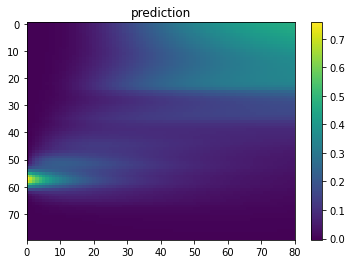

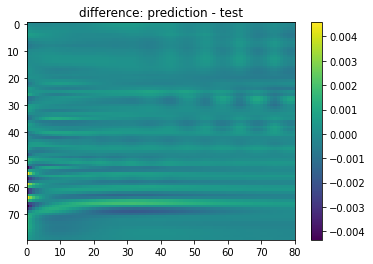

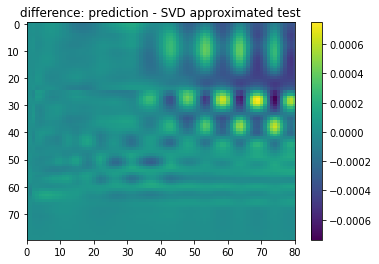

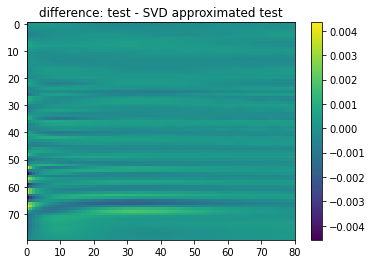

In [9]:
train_runs = runs[::1]
test_run = train_runs.pop(90)

NVAR.load_runs(train_runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, method='ridge', alpha=10.**-3.4, intercept=True, standardize=False, full_hist=False)

NVAR.print_status()


print('NVAR error: ', NVAR.get_error(test_run, norm='max') )
print('NVAR error compared to SVD approximated run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

pred = NVAR.predict_single_run(test_run)
test_run_SVDapprx = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = runs[0].shape[0]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()